# STEP0 : Define Goal
##### - Make models that predict passengers survival chance in the titanic accident for Prediction Competition at Kaggle.
##### - Practice and demonstration of the topics :

### Exploratory data analysis (EDA)
- statistics

#### Data Visulation
- Matplotlib
- Seaborn

#### Data cleaning, preprocessing, feature engineering
- Pandas
- Numpy
- pipelines

### Machine Learning Methods
- LogisticRegression
- DecisionTrees
- RandomForest

### Hyperparameter Optimization
- feature selection
- GridSearch

# STEP1 : Get Data & Libraries
##### Import libraries, load train data from Kaggle (already train/test splitted).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                 import metrics
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import plot_tree, DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing   import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute          import SimpleImputer
from impyute.imputation.cs   import mice

from sklearn.pipeline        import Pipeline, make_pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import FunctionTransformer

#from sklearn.metrics         import accuracy_score
#from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

In [ ]:
org_titanic      = pd.read_csv('./data/train.csv')
org_titanic_test = pd.read_csv('./data/test.csv')

# STEP2: Preprocessing & EDA 
##### Creating new features, cleaning and preprocessing, EDA 

In [2]:
# lowercase for feature names
org_titanic.columns = [i.lower() for i in org_titanic.columns]
org_titanic_test.columns = [i.lower() for i in org_titanic_test.columns]
# Copy original data 
main_df = org_titanic.copy()#.set_index('passengerid')

In [3]:
main_df.head(1)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Extract new features

In [5]:
def title_name(df):
    '''
    INPUT  : ['name']
    OUTPUT : ['title'] 
    
    Extract title and surname from 'name' feature.
    Rare titles are combined with common titles:
    - Mr.   = Dr.+Rev.+Don.
    - Mrs.  = Ms.+ Mme.
    - Miss. = Mlle.+Ms.(even not clear mariage status, more Miss. exist)
    - VIP   = Major.+Lady.+Sir.+Col.+the Countess.+Jonkheer. 
    '''    
    #df=temp_df
    df['title'] = df['name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
    df['surname'] = df['name'].apply(lambda x: x.split(',')[0])           
    
    # Modify titles 
    df.loc[df['title'].isin(['Mme.']), 'title']                                               = 'Mrs.'
    df.loc[df['title'].isin(['Mlle.','Ms.']), 'title']                                        = 'Miss.'
    df.loc[df['title'].isin(['Dr.', 'Rev.', 'Don.']), 'title']                                = 'Mr.'
    df.loc[df['title'].isin(['Major.', 'Lady.', 'Sir.', 'Col.', 'the', 'Jonkheer.']),'title'] = 'Vip.'
    
    df.drop(columns='name')
    return df#['title']

In [6]:
def define_groups(df):
    '''
    INPUT  : ['sibsp','parch']
    OUTPUT : ['famsize', 'grpsize']
    
    -Calculate (famsize) number of family members of all passengers. 
    -There are some friend groups. So one should check if there are different surnames in same ticket.
    '''
    df['famsize'] = df['sibsp']+df['parch']+1    
    df2 = df.groupby(['ticket','surname'])['famsize'].mean().groupby('ticket').sum().reset_index()
    df  = df.merge(df2, how='left', on='ticket')
    
    df.rename(columns={"famsize_x": "famsize", "famsize_y": "grpsize"}, inplace=True)
    
    df.drop(columns=['sibsp','parch'])
    return df #[['famsize', 'tic_grp']]

In [7]:
def prices(df):
    '''
    INPUT  : ['fare', 'famsize']
    OUTPUT : ['price']
    
    The tickets for multiple passengers show total price (It shown in Fare section). Calculate price per person for given fares. 
    (Assume that all families are on board and share same tickets! Can not calculate from 'fare' because data is alreadz train/test split)
    '''
    
    df['price'] = (df['fare'] / df['grpsize']).astype('int64')
    
    df.drop(columns='fare')
    return df

In [8]:
main_df = org_titanic.copy()
main_df = title_name(main_df)
main_df = define_groups(main_df)
main_df = prices(main_df)

## EDA: the Features

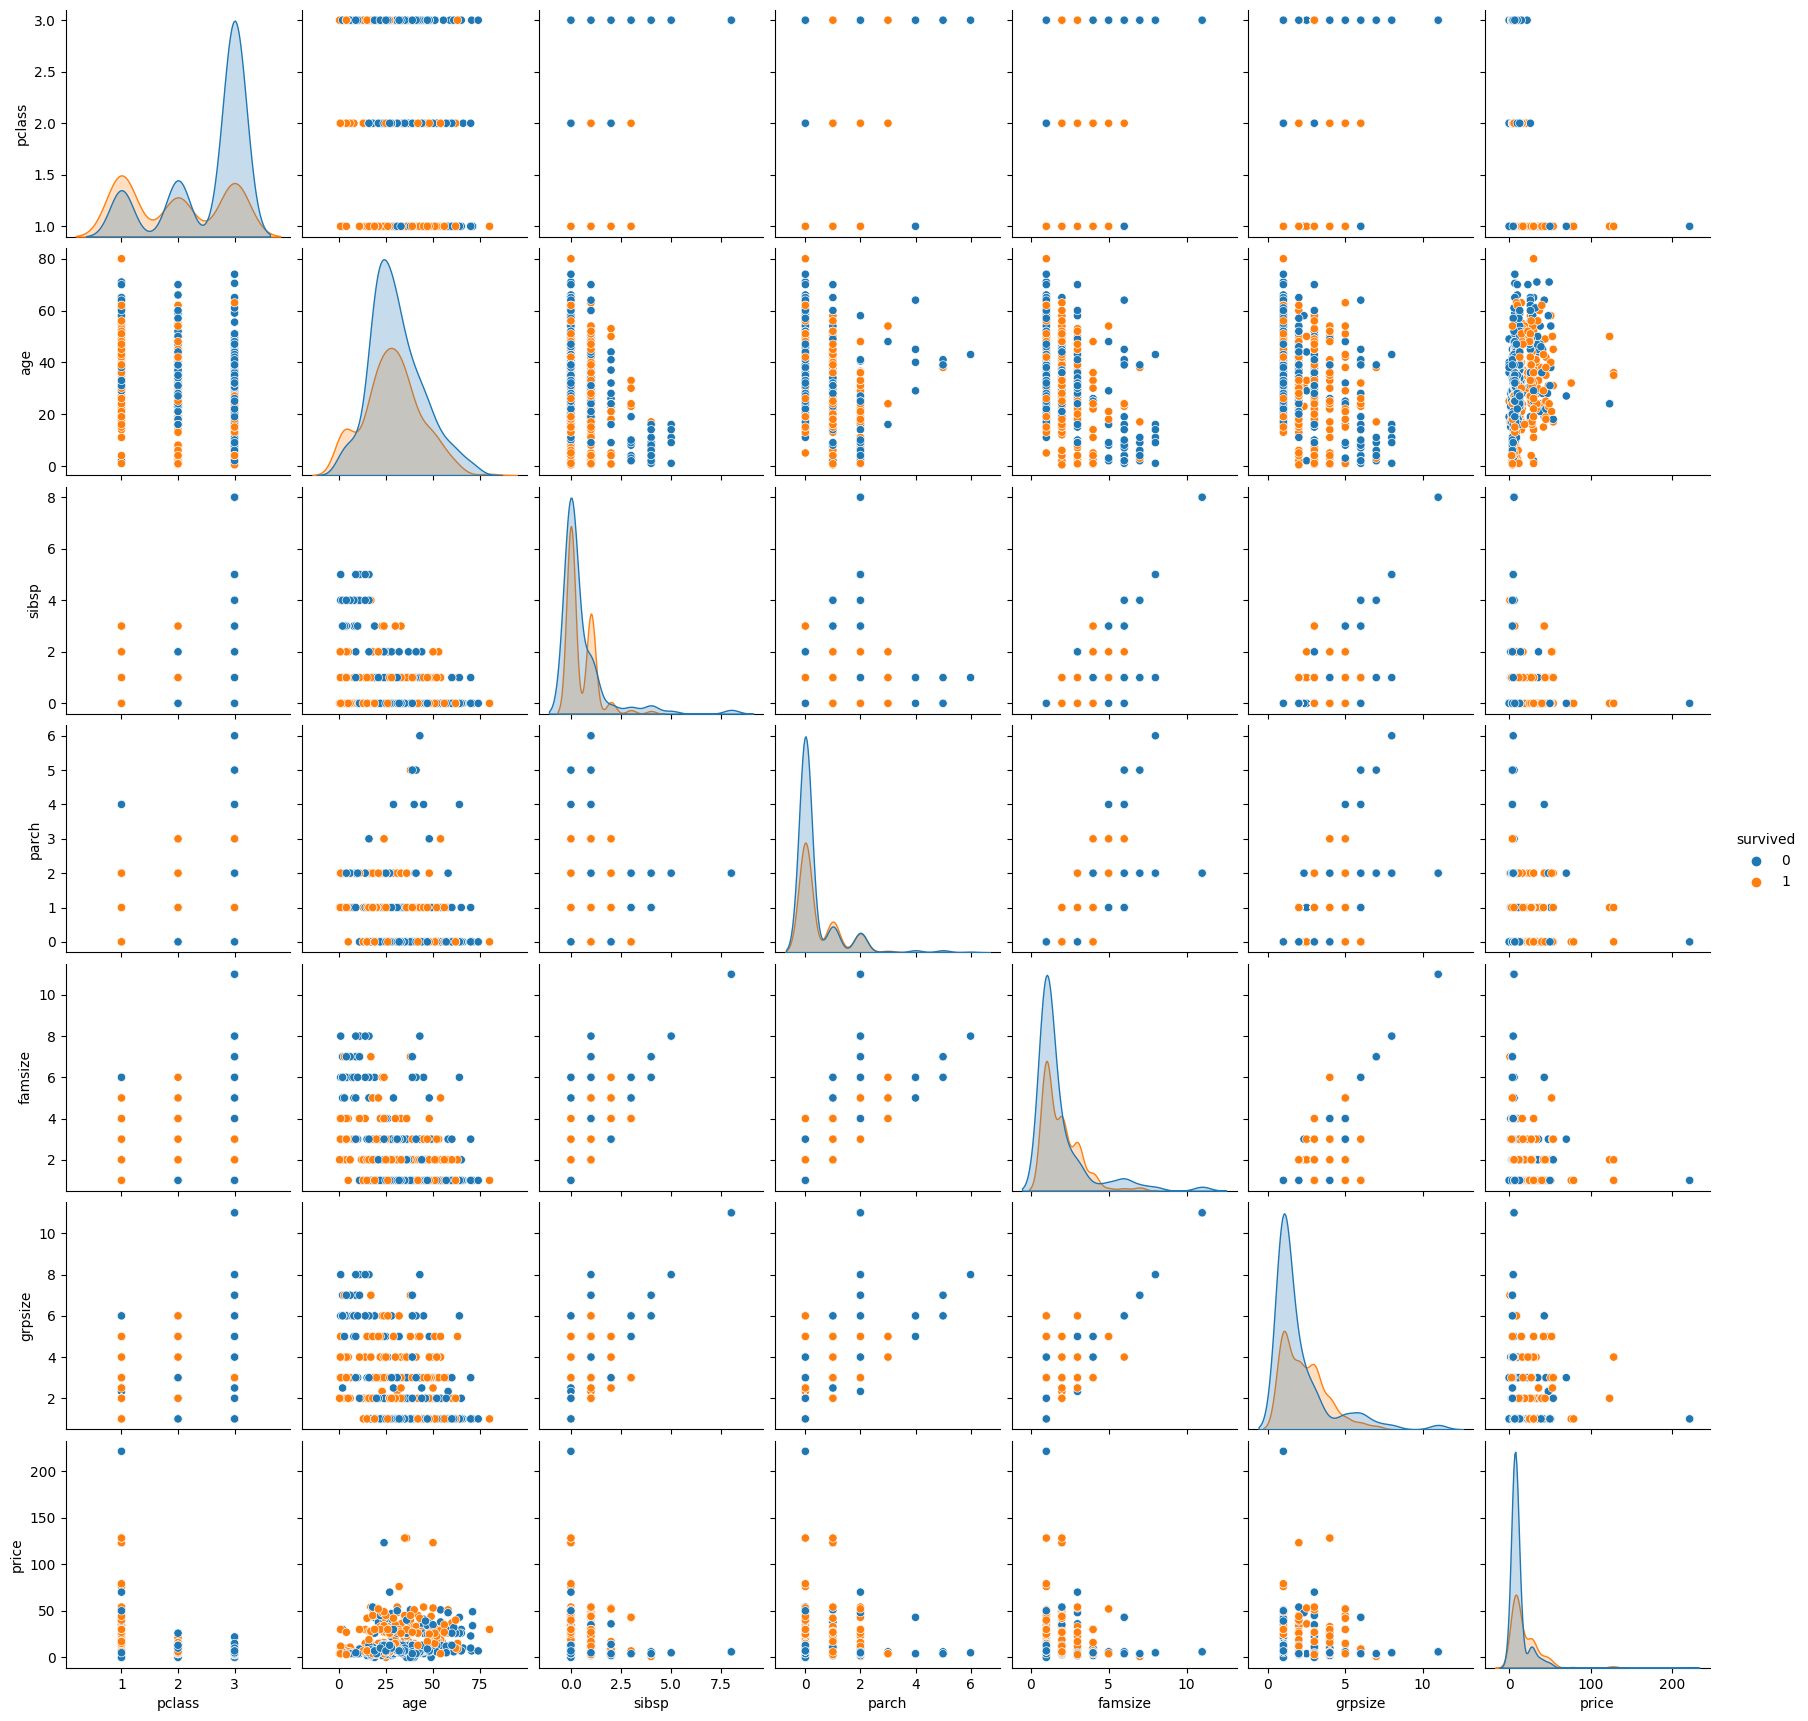

In [9]:
sns.pairplot(data=main_df.drop(columns=['passengerid','name', 'ticket', 'fare', 'cabin', 'surname']) , hue ='survived')

    **Survival  - Survival (0 = No; 1 = Yes). Not included in test.csv file.
    **pclass    - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    **name      - name
    **sex       - sex
    **age       - age
    **sibsp     - Number of Siblings/Spouses Aboard
    **parch     - Number of Parents/Children Aboard
    **ticket    - ticket Number
    **fare      - Passenger fare
    **Cabin     - Cabin
    **embarked  - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### **pclass**
#### **38%** of total passengers survived.

- **1st class :** **63%** of **216** 1st. passengers survived.
- **2nd class :** **47%** of **184** 2nd. passengers survived.
- **3rd class :** **24%** of **491** 3rd. passengers survived.

##### **embarked**
- **Southampton :** **34%** of **644** (from **1st**:20%, **2nd**:25%, **3rd**:55%) passengers survived.
- **Cherbourg :**   **55%** of **168** (from **1st**:51%, **2nd**:10%, **3rd**:39%) passengers survived.
- **Queenstown :**  **39%** of **77**  (from **1st**:3%, **2nd**:4%, **3rd**:94%) passengers survived.

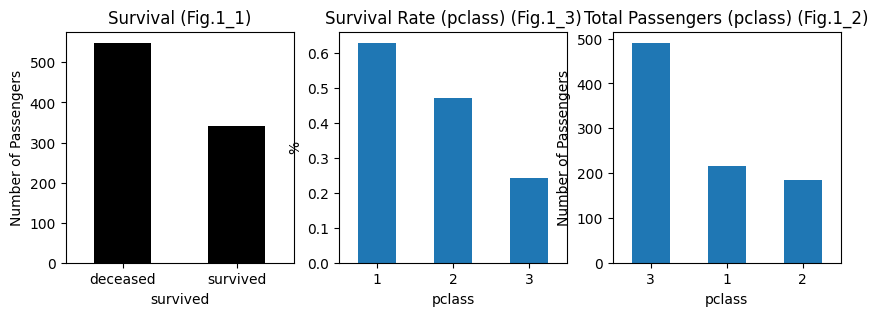

In [10]:
fig1, axs1 = plt.subplots(nrows=1, ncols=3, figsize=(10,3))


main_df['survived'].replace(0, 'deceased').replace(1, 'survived').value_counts().plot(kind='bar',
                                                                                     color='black',
                                                                                     title='Survival (Fig.1_1)',
                                                                                     ylabel='Number of Passengers',
                                                                                     ax=axs1[0],
                                                                                     rot=0)

main_df['pclass'].value_counts().plot(kind='bar',
                                    title='Total Passengers (pclass) (Fig.1_2)',
                                    xlabel='pclass',
                                    ylabel='Number of Passengers',
                                    ax=axs1[2],
                                    rot=0)


main_df.groupby('pclass')['survived'].mean().plot(kind='bar',
                                                title='Survival Rate (pclass) (Fig.1_3)',
                                                ylabel='%',
                                                xlabel='pclass',
                                                rot=0,
                                                ax=axs1[1])

plt.show()

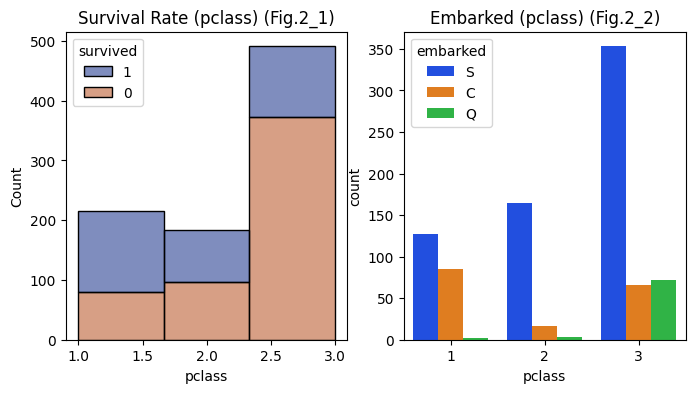

In [11]:
# plotting with seaborn
fig2, axs2 = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=main_df,
             x='pclass',
             stat='count',
             hue='survived',
             palette='dark',
             hue_order=[1,0],
             alpha=0.5,
             bins=3,
             ax=axs2[0],
             multiple="stack").set(title='Survival Rate (pclass) (Fig.2_1)')

sns.countplot(data=main_df,
            x='pclass', hue='embarked',
            palette='bright',
            alpha=1,
            ax=axs2[1]).set(title='Embarked (pclass) (Fig.2_2)')

plt.show()

### **sex**
##### **Gender**
- **35%** of total **891** passengers are **female**.
- **74%** of **314 Female** (from **1st**:30%, **2nd**:24%, **3rd**:46%) passengers survived.
- **19%** of **577 Male**   (from **1st**:21%, **2nd**:19%, **3rd**:60%) passengers survived.

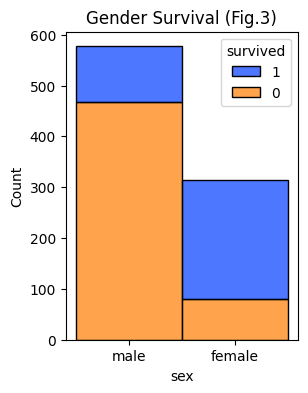

In [12]:
fig3, axs3 = plt.subplots(1, 1, figsize=(3, 4))
sns.histplot(data=main_df,
             x='sex',
             stat='count',
             hue='survived',
             palette='bright',
             hue_order=[1,0],
             alpha=0.7,
             bins=10,
             multiple="stack").set(title='Gender Survival (Fig.3)')
plt.show()

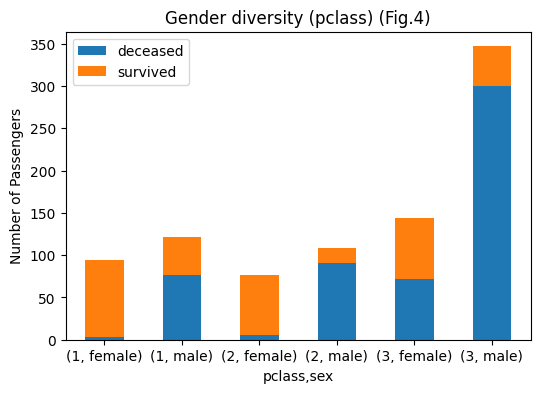

In [13]:
fig4, axs4 = plt.subplots(1, 1, figsize=(4, 4))
main_df.groupby(['pclass', 'sex','survived']).size().unstack().plot.bar(title='Gender diversity (pclass) (Fig.4)', 
                                                                 ylabel  = 'Number of Passengers',
                                                                 rot     = 0,
                                                                 stacked = True,
                                                                 figsize = (6,4), 
                                                                 ax      = axs4)
plt.legend(['deceased','survived'])
plt.show()

### **age**
##### **Survival Rate (age)** Fig.2_1 :
- Children (<8) : 0.68
- Youth (8-18) 0.40
- Adults (51-65): 0.39
- Seniors (>66) : 0.13

##### Deceased/survived age:
- Deceased median age: **Male** 29, **Female** 24
- survived median age: **Male** 28, **Female** 28

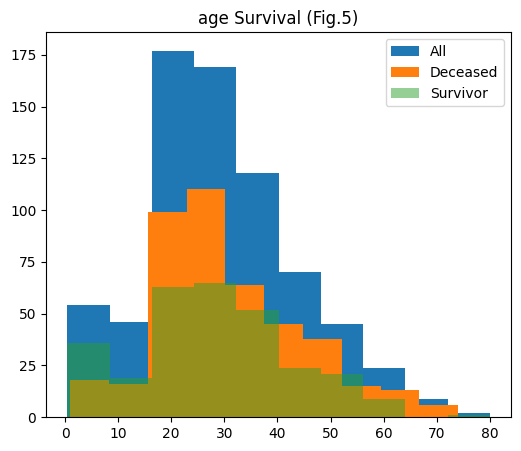

In [14]:
main_df.loc[:,'age'].hist()
main_df.loc[main_df['survived'] == 0, 'age'].hist()
main_df.loc[main_df['survived'] == 1, 'age'].hist(alpha=0.5,
                                                          figsize=(6,5),
                                                          #bins=8,
                                                          grid=False).set(title='age Survival (Fig.5)')
plt.legend(['All', 'Deceased', 'Survivor'])

[Text(0.5, 1.0, 'age (embarked) (Fig.6_4)')]

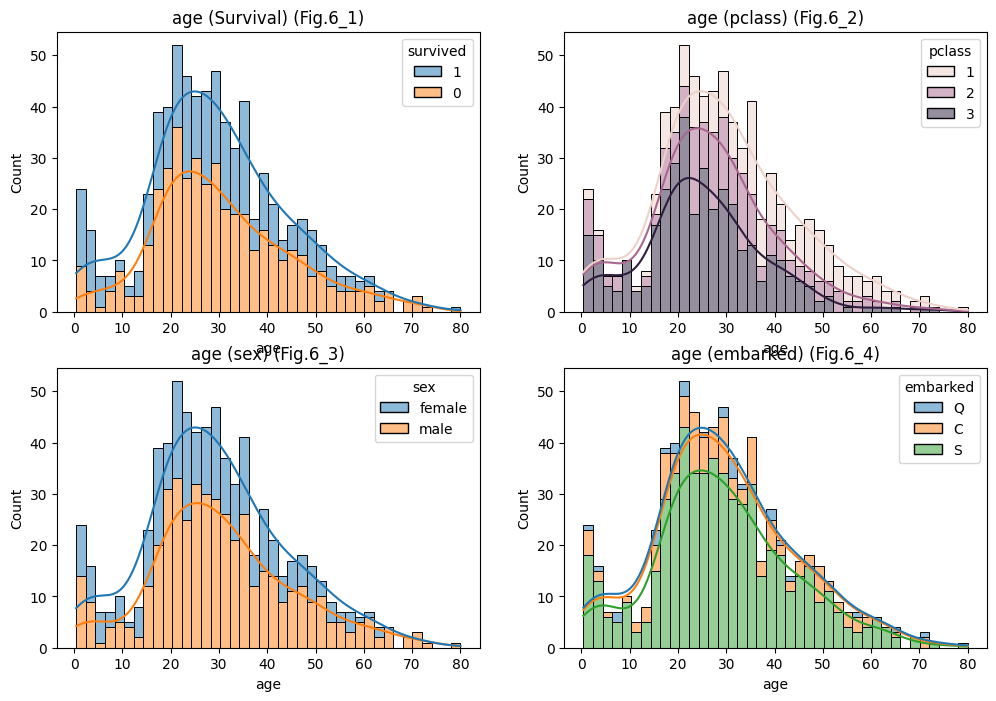

In [15]:
fig6, axs6 = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(data=main_df, x="age", hue='survived', hue_order=[1,0],             kde=True, color="skyblue", bins=40, multiple="stack", ax=axs6[0, 0]).set(title='age (Survival) (Fig.6_1)')
sns.histplot(data=main_df, x="age", hue='pclass',                                kde=True, color="olive",   bins=40, multiple="stack", ax=axs6[0, 1]).set(title='age (pclass) (Fig.6_2)')
sns.histplot(data=main_df, x="age", hue='sex',      hue_order=['female','male'], kde=True, color="gold",    bins=40, multiple="stack", ax=axs6[1, 0]).set(title='age (sex) (Fig.6_3)')
sns.histplot(data=main_df, x="age", hue='embarked', hue_order=['Q','C','S'],     kde=True, color="teal",    bins=40, multiple="stack", ax=axs6[1, 1]).set(title='age (embarked) (Fig.6_4)')

## EDA: New Features

- title  =  '**Mr.**': ('Dr.','Rev','Don'), '**Mrs.**'; ('Mme.'), '**Miss.**': ('Mlle.','Ms.'), '**Master.**', '**Capt.**', '**Vip.**': ('Major.','Lady.', 'Sir.', 'Col.', 'the Countess.', 'Jonkheer.')
- surname  =  Last name of passenger
- price  =  Ticket price per person
- famsize  =  Number of family members (sibsp+parch+1)
- grpsize = friend group or families with friends
- tic_grp  =  Number of groups (groupby 'ticket')

### **price** (extract from fare)
#### One can see from Fig.7_1-3 and calculations below that **fare** is not single ticket prices, but total price of the groups. 
###### *(Here calculating 'price' from 'ticket'.value_counts() would be better approach but our data already train-split from Kaggle, so we dont have full data!)*
Fig.7_1-3: '**fare**' has very broad distribution and big difference between prices that indicates 'fare' is prices not for a single passenger, but group price. Comparing with calculated '**price**' feature, as expected, distribution gets narrower and differences lesser.

#### Fig.7-4-6: See '**price**' distribution without outliners for classes. 
- Some Max prices are very high for each Pclass. That can be speculated likely friend groups etc. that are not native but share same ticket. Our function do not consider that so far.
- There are passengers with **zero 'fare'**. Assumed as free-tickets since one of those has 'Jonkheer.' title.
- Comparing median of prices of different Pclasses: 2nd class tickes **double of 3rd** and 1st class **2.5 times of 2nd class**. 

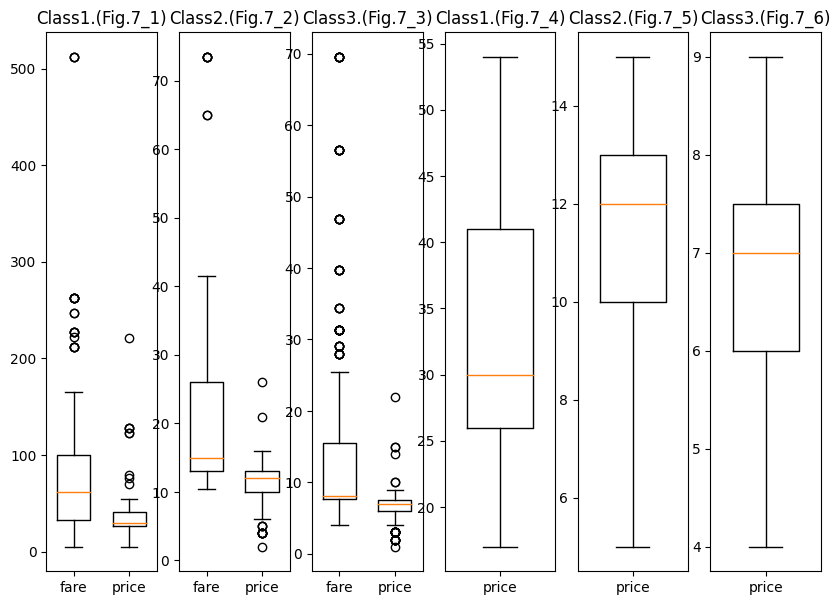

In [16]:
fig7, ax7 = plt.subplots(nrows=1, ncols=6, figsize=(10,7))

for i in range(1, 4):
    ax7[i-1].boxplot([main_df.loc[(main_df['price'] != 0) & (main_df['pclass'] == i), 'fare']],
                     positions=[1], widths=0.6)

    ax7[i-1].boxplot([main_df.loc[(main_df['price'] != 0) & (main_df['pclass'] == i), 'price']],
                     positions=[2], widths=0.6)
    ax7[i-1].set_xticks([1, 2])
    ax7[i-1].set_xticklabels(['fare', 'price'])
    ax7[i-1].set_title(f'Class{i}.(Fig.7_{i})'.format(i))


for i in range(3, 6):
    ax7[i].boxplot(
        [main_df.loc[(main_df['price'] != 0) & (main_df['pclass'] == i-2), 'price']],
        positions=[1], widths=0.6, whis=[5, 95], showfliers=False)
    ax7[i].set_xticks([1])
    ax7[i].set_xticklabels(['price'])
    ax7[i].set_title(f'Class{i-2}.(Fig.7_{i+1})'.format(i-2))


plt.show()

<Axes: xlabel='pclass,price'>

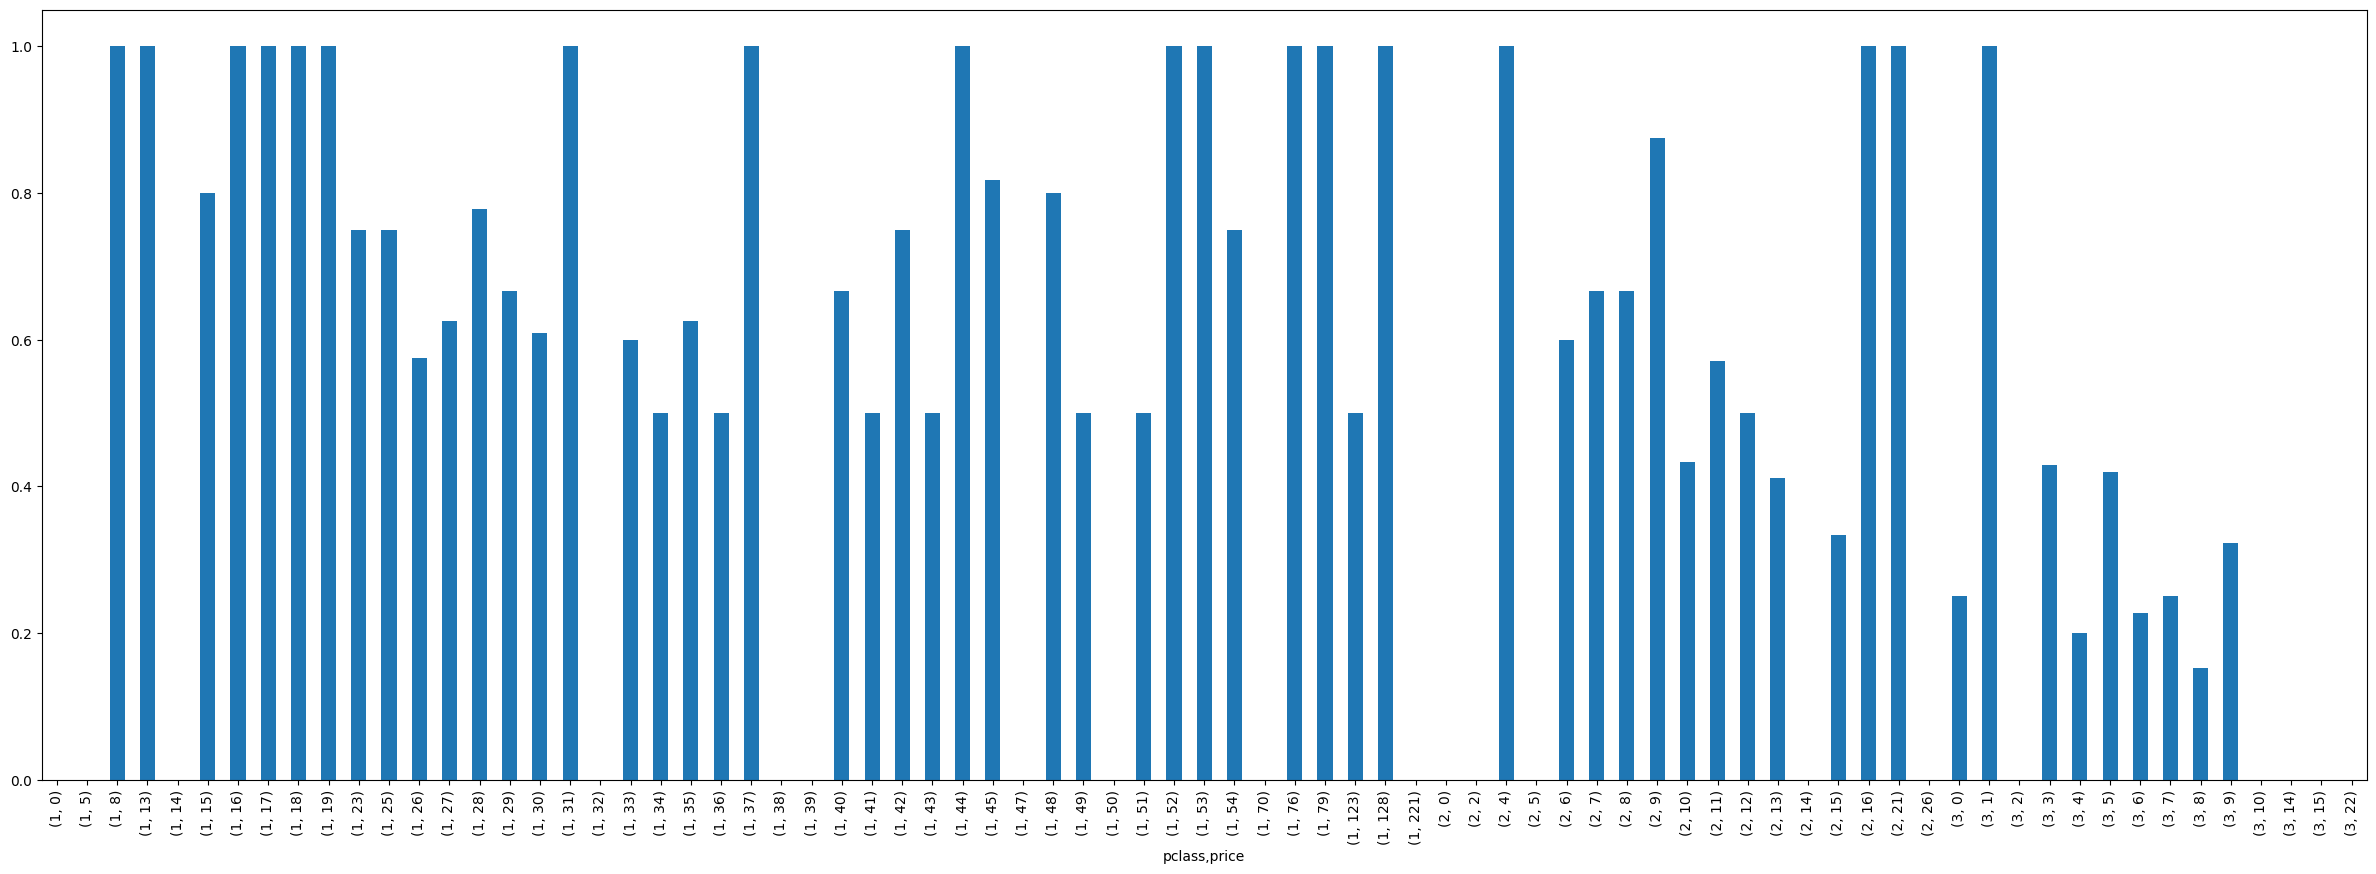

In [17]:
main_df.groupby(['pclass','price'])['survived'].mean().plot.bar(figsize=(30,10))

In [18]:
print('---------------------------------- fare:')
print('--------------- pclass 1:')
print('single ticket for one person:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==1)]['fare'].median())
print('multi ticket for one person:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==1)]['fare'].median())
print('--------------- pclass 2:')
print('single ticket for one person:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==2)]['fare'].median())
print('multi ticket for one person:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==2)]['fare'].median())
print('--------------- pclass 3:')
print('single ticket for one person:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==3)]['fare'].median())
print('multi ticket for one person:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==3)]['fare'].median())


print('---------------------------------- prices:')
print('--------------- pclass 1:')
print('single ticket:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==1)]['price'].median())
print('multi ticket:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==1)]['price'].median())
print('both', main_df.loc[(main_df['pclass'] ==1)]['price'].median())
print('--------------- pclass 2:')
print('single ticket:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==2)]['price'].median())
print('multi ticket:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==2)]['price'].median())
print('both', main_df.loc[(main_df['pclass'] ==2)]['price'].median())
print('--------------- pclass 3:')
print('single ticket:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==3)]['price'].median())
print('multi ticket:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==3)]['price'].median())
print('both', main_df.loc[(main_df['pclass'] ==3)]['price'].median())


---------------------------------- fare:
--------------- pclass 1:
single ticket for one person: 31.0
multi ticket for one person: 79.65
--------------- pclass 2:
single ticket for one person: 13.0
multi ticket for one person: 26.0
--------------- pclass 3:
single ticket for one person: 7.8958
multi ticket for one person: 18.0
---------------------------------- prices:
--------------- pclass 1:
single ticket: 30.0
multi ticket: 30.0
both 30.0
--------------- pclass 2:
single ticket: 13.0
multi ticket: 9.5
both 12.0
--------------- pclass 3:
single ticket: 7.0
multi ticket: 5.0
both 7.0


### title

Titles :  ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Vip.' 'Capt.']


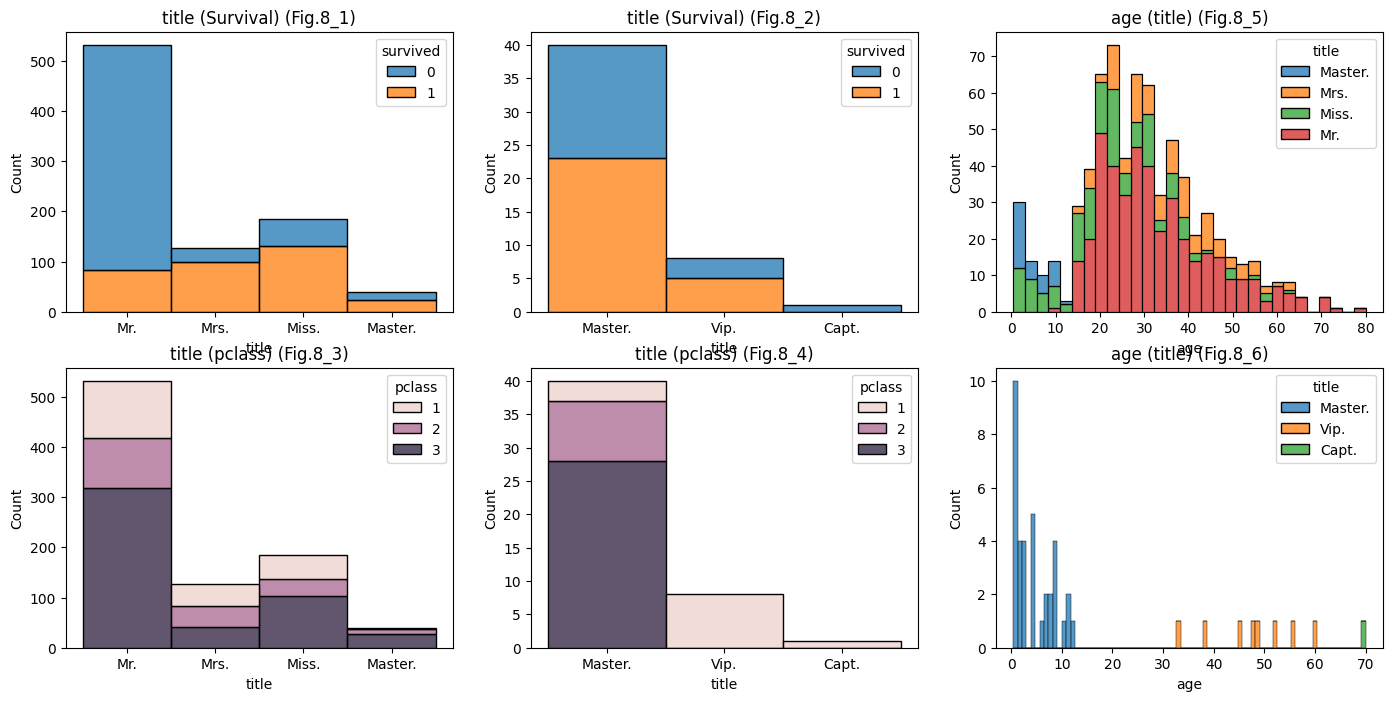

In [19]:
print('Titles : ',main_df['title'].unique())

fig8, axs8 = plt.subplots(2, 3, figsize=(17, 8))

sns.histplot(data=main_df.loc[main_df['title'].isin(['Mr.','Miss.','Mrs.','Master.'])], 
             x="title", hue='survived',
             color="skyblue", bins=4, 
             multiple="stack", ax=axs8[0, 0]).set(title='title (Survival) (Fig.8_1)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Master.', 'Vip.', 'Capt.'])], 
             x="title", hue='survived',
             color="skyblue", bins=10, 
             multiple="stack", ax=axs8[0, 1]).set(title='title (Survival) (Fig.8_2)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Mr.','Miss.','Mrs.','Master.'])], 
             x="title", hue='pclass',
             color="skyblue", bins=40, 
             multiple="stack", ax=axs8[1, 0]).set(title='title (pclass) (Fig.8_3)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Master.', 'Vip.', 'Capt.'])], 
             x="title", hue='pclass',
             color="skyblue", bins=40, 
             multiple="stack", ax=axs8[1, 1]).set(title='title (pclass) (Fig.8_4)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Mr.','Miss.','Mrs.','Master.'])], 
             x="age", hue='title', hue_order=['Master.', 'Mrs.', 'Miss.', 'Mr.'],
             color="skyblue", bins=30, 
             multiple="stack", ax=axs8[0, 2]).set(title='age (title) (Fig.8_5)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Master.', 'Vip.', 'Capt.'])], 
             x="age", hue='title',
             color="skyblue", bins=80, 
             multiple="stack", ax=axs8[1, 2]).set(title='age (title) (Fig.8_6)')
plt.show()

### famsize

<Axes: title={'center': 'Family Size (pclass) (Fig.9)'}, ylabel='pclass'>

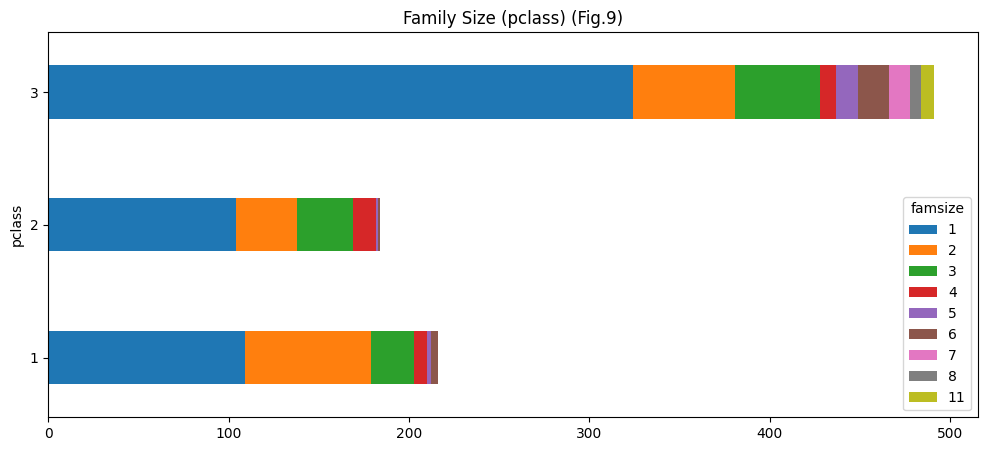

In [20]:
main_df.groupby(['pclass', 'famsize']).size().unstack().plot.barh(title='Family Size (pclass) (Fig.9)', 
                                                                 stacked=True,
                                                                 width=0.4,
                                                                 figsize=(12,5))





dsda

### Calculations

In [21]:
print('Average age of survived and Deceased Passengers :')
print(org_titanic.groupby(['survived','sex'])['age'].median().astype('int64'))
print('---------------------------------------------------------')
print('Survival Ratio in age groups :')
print('Children (<8) :', org_titanic.loc[org_titanic['age']<8]['survived'].mean())
print('Youth (8-18)', org_titanic.loc[(org_titanic['age']>=8) & (org_titanic['age']<19)]['survived'].mean())
print('Adults (51-65):',org_titanic.loc[(org_titanic['age']>=(19)) & (org_titanic['age']<(66))]['survived'].mean())
print('Seniors (>66) :', org_titanic.loc[org_titanic['age']>=66]['survived'].mean())

Average age of survived and Deceased Passengers :
survived  sex   
0         female    24
          male      29
1         female    28
          male      28
Name: age, dtype: int64
---------------------------------------------------------
Survival Ratio in age groups :
Children (<8) : 0.68
Youth (8-18) 0.4044943820224719
Adults (51-65): 0.3862433862433862
Seniors (>66) : 0.125


In [22]:
print(round(org_titanic.groupby('pclass')['survived'].mean(),2))
print('---------------------------------------------------------')
print(round(org_titanic.groupby('pclass')['survived'].mean(),2))
print('---------------------------------------------------------')
print('Number of Passengers per pclass :')
print(org_titanic['pclass'].value_counts())
print('Survival Rate :', round(org_titanic['survived'].mean(),2))
print('---------------------------------------------------------')
print('Precentage of Total Passengers:')
print(round(org_titanic['pclass'].value_counts()/org_titanic['pclass'].count(),2))
print('---------------------------------------------------------')
print('Survival % per pclass :')
print(round(org_titanic.groupby('pclass')['survived'].mean(),2))

pclass
1    0.63
2    0.47
3    0.24
Name: survived, dtype: float64
---------------------------------------------------------
pclass
1    0.63
2    0.47
3    0.24
Name: survived, dtype: float64
---------------------------------------------------------
Number of Passengers per pclass :
pclass
3    491
1    216
2    184
Name: count, dtype: int64
Survival Rate : 0.38
---------------------------------------------------------
Precentage of Total Passengers:
pclass
3    0.55
1    0.24
2    0.21
Name: count, dtype: float64
---------------------------------------------------------
Survival % per pclass :
pclass
1    0.63
2    0.47
3    0.24
Name: survived, dtype: float64


In [23]:
print('Gender :')
print(org_titanic['sex'].value_counts())
print('---------------------------------------------------------')
print('Gender Survival % per pclass :')
print(round(org_titanic.groupby('sex')['survived'].mean(),2))
print('---------------------------------------------------------')
print(round(((org_titanic.groupby(['sex','pclass'])['passengerid'].count())/ (org_titanic.groupby(['sex'])['passengerid'].count())), 2))

Gender :
sex
male      577
female    314
Name: count, dtype: int64
---------------------------------------------------------
Gender Survival % per pclass :
sex
female    0.74
male      0.19
Name: survived, dtype: float64
---------------------------------------------------------
sex     pclass
female  1         0.30
        2         0.24
        3         0.46
male    1         0.21
        2         0.19
        3         0.60
Name: passengerid, dtype: float64


In [24]:
print('Survival(embarked) :')
print(round(org_titanic['embarked'].value_counts()))
print('-----------------------')
print(round(org_titanic.groupby('embarked')['survived'].mean(),2))
print('-----------------------')
print(round(((org_titanic.groupby(['embarked','pclass'])['passengerid'].count())/ (org_titanic.groupby(['embarked'])['passengerid'].count())), 2))

Survival(embarked) :
embarked
S    644
C    168
Q     77
Name: count, dtype: int64
-----------------------
embarked
C    0.55
Q    0.39
S    0.34
Name: survived, dtype: float64
-----------------------
embarked  pclass
C         1         0.51
          2         0.10
          3         0.39
Q         1         0.03
          2         0.04
          3         0.94
S         1         0.20
          2         0.25
          3         0.55
Name: passengerid, dtype: float64


## Cleaning: Fill missing values

### Check missing & zero values
- **age** 173 missing values.
- In **Cabin** almost 75% data missing! Care to use!
- **embarked** has 2 missing values.
- **fare** has 15 **zero** values.

### Check unique values
- (**Passenger Id** vs **name**), **survived**, **pclass**, **sex**, **embarked**: unique values look OK.
- Some **ticket** numbers shared by more than one person.
- Max value of **sibsp** vs **parch** also fit to each other
- Some **Cabin** number did not specified for the passenger but the group. One can still assume the cabins are located close to each other. 
- **fare** looks like total price for the group ticket

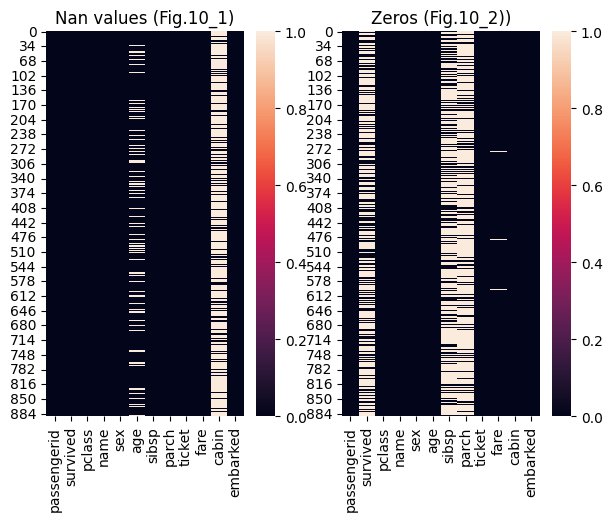

15  fare is missing.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [25]:
fig10, axs10 = plt.subplots(1, 2, figsize=(7, 5))
sns.heatmap(data=org_titanic.isna(), ax=axs10[0]).set_title('Nan values (Fig.10_1)')
sns.heatmap(data=org_titanic==0, ax=axs10[1]).set_title('Zeros (Fig.10_2))')
plt.show()

print(org_titanic.loc[org_titanic['fare'] == 0]['passengerid'].count(), ' fare is missing.')
print(org_titanic.info())

### Imputation

#### '**cabin**'

There are many missing values in cabin feature. It can be categorized as known(1) or unknown(0). 

In [26]:
def cabin_filled (df):
    df['cabin_f_cat'] = df['cabin'].fillna(value=0)
    df.loc[df['cabin_f_cat']!=0, 'cabin_f_cat'] = 1
    df.drop(columns='cabin')
    return df

#### '**embarked**'

There are **two missing values** in embarked. The missing values belong to the ticket=113572. Similar serial_numbers belong to S and C. Mainly S ...
**So set them to 'S'**

In [27]:
#main_df.sort_values('ticket')[29:51]
def embarked_filled (df):
    df.loc[df['embarked'].isna(), 'embarked'] = 'S'
    df['emb_fill']=df['embarked']
    df.drop(columns='embarked')
    return df

#### '**age**'

##### An additional feature for age after impute.

In [28]:
def age_groups(df):
    '''
    INPUT  : ['age']
    OUTPUT : ['age_group']
    
    -Define passengers age groups: 'age_group'
    ''' 
    
    df['age_group'] = 0
    df.loc[(df['age'] >  8), 'age_group']                     = 1
    df.loc[(df['age'] >= 8)  & (df['age'] < 19), 'age_group'] = 2
    df.loc[(df['age'] >= 19) & (df['age'] < 51), 'age_group'] = 3
    df.loc[(df['age'] >= 51) & (df['age'] < 66), 'age_group'] = 4
    df.loc[(df['age'] >= 66),'age_group']                     = 5

    return df

##### **Method 1**: Ampute missing values according to 'title'

Median Age - title
Capt.      70
Master.     3
Miss.      21
Mr.        30
Mrs.       35
Vip.       48
Name: age, dtype: int64
________________________________________________
Titles with missing values :  ['Mr.' 'Mrs.' 'Miss.' 'Master.']
________________________________________________
(Missing)/(tit_total):
Mr.:  0.23  Mrs.:  0.13  Miss.:  0.19  Master.:  0.1
________________________________________________


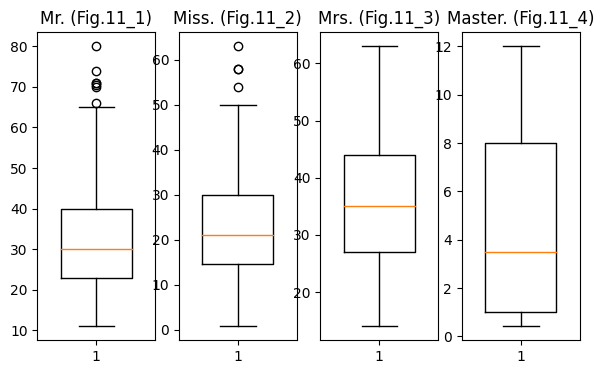

In [29]:
print('Median Age -', main_df.groupby('title')['age'].median().astype('int64'))
print('________________________________________________')

print('Titles with missing values : ', main_df.loc[main_df['age'].isna()]['title'].unique())
print('________________________________________________')

# To be sure that it is a good assumption:
print('(Missing)/(tit_total):')
print('Mr.: ',     round(119/517,2), ' Mrs.: ',    round(17/126,2), ' Miss.: ',   round(36/185,2), ' Master.: ', round(4/40,2))
# Highest for Mr. with 23%. Eventhough it is quite high, lets assume it is OK for our purpose.
print('________________________________________________')


fig3, ax3 = plt.subplots(nrows=1, ncols=4, figsize=(7,4))
ax3[0].boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Mr.'],    widths=0.6)
ax3[0].set_title('Mr. (Fig.11_1)')
ax3[1].boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Miss.'],   widths=0.6)
ax3[1].set_title('Miss. (Fig.11_2)')
ax3[2].boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Mrs.'],    widths=0.6)
ax3[2].set_title('Mrs. (Fig.11_3)')
ax3[3].boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Master.'],  widths=0.6)
ax3[3].set_title('Master. (Fig.11_4)')
plt.show()

In [30]:
def age_filled_tit (df):
    df['age_filled_tit'] = df['age']
    df.loc[(df['age_filled_tit'].isna()) & (df['title']=='Mr.'), 'age_filled_tit']     = df.loc[df['title'] == 'Mr.']['age_filled_tit'].median()
    df.loc[(df['age_filled_tit'].isna()) & (df['title']=='Miss.'), 'age_filled_tit']   = df.loc[df['title'] == 'Miss.']['age_filled_tit'].median()
    df.loc[(df['age_filled_tit'].isna()) & (df['title']=='Mrs.'), 'age_filled_tit']    = df.loc[df['title'] == 'Mrs.']['age_filled_tit'].median()
    df.loc[(df['age_filled_tit'].isna()) & (df['title']=='Master.'), 'age_filled_tit'] = df.loc[df['title'] == 'Master.']['age_filled_tit'].median()
    #df.loc[(df['age_filled_tit'].isna()) & (df['title']=='Dr.'), 'age_filled_tit']     = df.loc[df['title'] == 'Dr.']['age_filled_tit'].median()
    
    return df

##### **Method 2**: Ampute missing values with MICE package'